<a href="https://colab.research.google.com/github/UdeS-PMF/gmq710_test/blob/develop/Pratique_avec_Yolo_et_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifier des objets dans une image

## Objectif

Utiliser un réseau entraîné avec OpenCV pour détecter les objets dans une image. Cette approche fonctionne bien si les objets à trouver sont dans la liste des objets reconnus par le réseau.

Yolo utilise en général 80 classes de la vie courante :



```
person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
...
```


## Besoins

On utilise OpenCV pour la lecture des images et l'application du réseau YOLO.

Pour mettre en place YOLO, on a besoin du fichier config (cfg), des poids (weights) et de la liste des classes (coco.names).



# Mettre en place l'application

On importe OpenCV et les autres libs

In [ ]:
import cv2
import numpy as np

import time
import sys
import os
import glob
import requests
from io import BytesIO

On définit le réseau YOLO (on peut télécharger le réseau à cette adresse : https://drive.google.com/file/d/1zzcqh7i9G0VhT1zN67ZBOjYfeHGCuOM5/view?usp=sharing)

Ce fichier zip fournira les paramètres de Yolo4.

In [ ]:
!unzip /content/yolov4.zip -d /content/model_data

Archive:  /content/yolov4.zip
  inflating: /content/model_data/coco.names  
  inflating: /content/model_data/yolov4.cfg  
  inflating: /content/model_data/yolov4.weights  


In [ ]:
# on peut changer les paramètres si on obtient trop de résultats
CONFIDENCE = 0.1
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.8

# La configuration du réseau de neurones
config_path = "/content/model_data/yolov4.cfg"
# Les poids du réseau
weights_path = "/content/model_data/yolov4.weights"

# les classes
labels = open("/content/model_data/coco.names").read().strip().split("\n")
# la table de couleurs
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# on charge le réseau
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)


On définit l'image à analyser (un lien url ou une image sur le disque)

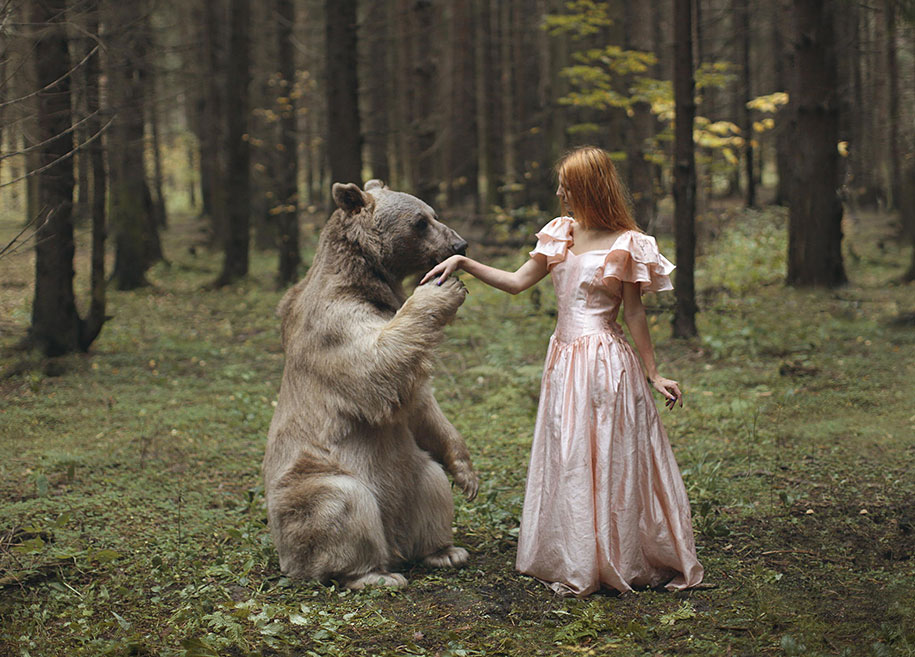

In [ ]:
# on lit une image sur internet
path_name = "http://static.demilked.com/wp-content/uploads/2014/04/surreal-animal-human-portraits-katerina-plotnikova-21.jpg"
response = requests.get(path_name)
image_data = BytesIO(response.content)
image = cv2.imdecode(np.asarray(bytearray(image_data.read()), dtype=np.uint8), cv2.IMREAD_COLOR)

# si on veut analyser une image sur le disque
# path_name = '/content/car.jpg'
# image = cv2.imread(path_name)

# on détermine le nom du fichier
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

# Affichage de l'image
from google.colab.patches import cv2_imshow
cv2_imshow(image)

On analyse l'image avec le réseau YOLO à l'aide de OpenCV.

In [ ]:
%time
h, w = image.shape[:2]
# on va créer une image selon la taille attendue par le réseau
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# on envoie l'image dans le réseau
net.setInput(blob)

# on va récupérer la dernière couche du réseau
ln = net.getLayerNames()
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    # in case getUnconnectedOutLayers() returns 1D array when CUDA isn't available
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]


# on peut calculer le temps mis par l'analyse
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs
Time took: 2.24s


On récupère la réponse du réseau

* la boite englobante de l'objet
* la confiance sur la détection
* l'objet détecté (la classe)



In [ ]:
boxes, confidences, class_ids = [], [], []
# on analyse les sorties du réseau
for output in layer_outputs:
    # on récupère la détection
    for detection in output:
        # on cherche la classe la plus forte
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # on peut limiter notre intérêt sur les plus forte détection
        if confidence > CONFIDENCE:
            # on obtient la boite englobante
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")

            # le coin x, y
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # on récupère la boite, la confiance et la classe
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

On va créer une image pour montrer le résultat

In [ ]:
# on peut nettoyer les régions trouvées
idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)
font_scale = 1
thickness = 1
# on parcourt les régions trouvées et on affiche sur l'image originale
for i in idxs.flatten():
    # la boite englobante
    x, y = boxes[i][0], boxes[i][1]
    w, h = boxes[i][2], boxes[i][3]
    # on change de couleur selon la classe
    color = [int(c) for c in colors[class_ids[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
    text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
    # on définit la taille du texte
    (text_width, text_height) = \
    cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y - 5
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
    overlay = image.copy()
    cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
    # on ajoute la boite en transparence
    image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    # on ajoute le texte
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

# on sauvegarde l'image
#cv2.imwrite('/content/'+filename + "_yolo3." + ext, image)

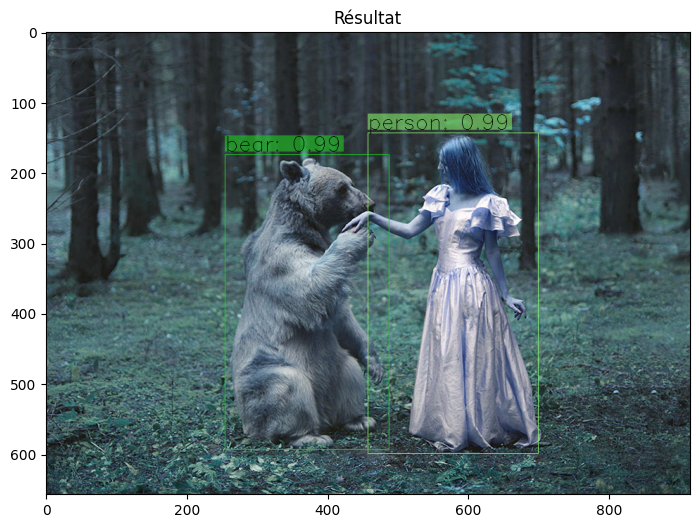

In [ ]:
import matplotlib.pyplot as plt

# Afficher les images dans Colab
plt.figure(figsize=(12, 6))

# Afficher l'image originale
plt.subplot(1, 1, 1)
plt.imshow(image)
plt.title('Résultat')

plt.show()